<a href="https://colab.research.google.com/github/TARTAR4600/CASA0003/blob/main/%E2%80%9Cmain_analysing_code%E2%80%9D%E9%AB%98R%E6%96%B9XGBoost%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import numpy as np

path = "/content/2016_with_commercial_car_GG_ele_rough_BCR_max.csv"
df = pd.read_csv(path)
df= df.drop_duplicates()

# ===== 你的原始过滤逻辑（用于正样本）=====
mask_core = (df["sky_ratio"].notna()) & (df["sky_ratio"] != 0) & (df["count_objects_sum"] .notna())
mask_murder_pos = (df["Cantidad"].notna()) & (df["Cantidad"] != 0)

df_positive = df[mask_core & mask_murder_pos].copy()
print(f"原始过滤得到正样本行数：{len(df_positive)}")

# ===== 可选：负样本抽取 =====
USE_NEGATIVE_SAMPLING = True
NEGATIVE_N = 0
RANDOM_SEED = 33

if USE_NEGATIVE_SAMPLING:
    mask_murder_zero = (df["Cantidad"].notna()) & (df["Cantidad"] == 0)
    df_negative_pool = df[mask_core & mask_murder_zero].copy()
    n_pick = min(NEGATIVE_N, len(df_negative_pool))
    if n_pick > 0:
        df_negative_sampled = df_negative_pool.sample(n=n_pick, random_state=RANDOM_SEED)
    else:
        df_negative_sampled = df_negative_pool.iloc[0:0]  # 空表
    df_input = pd.concat([df_positive, df_negative_sampled], ignore_index=True)
    print(f"负样本池：{len(df_negative_pool)}，实际抽取：{n_pick}；合并后总行数：{len(df_input)}")
else:
    df_input = df_positive
    print(f"未抽取负样本；当前总行数：{len(df_input)}")

# ===== 特征工程 =====
df_input = df_input.copy()
df_input["commercial_density_log"] = np.log1p(df_input["count_objects_sum"] / (df_input["area_m2"]/1000000))
df_input["graffiti_density_log"]   = np.log1p(df_input["graffiti_count"]/ (df_input["area_m2"]/1000000))
df_input["murder_density"] = df_input["Cantidad"]/ (df_input["area_m2"]/1000000)
df_input["murder_density_log"]     = np.log1p(df_input["murder_density"])
df_input["street_density"] = df_input['street_total_length'] / (df_input["area_m2"]/1000000)
df_input["BCR_building_interaction"] = df_input["BCR"] * df_input["building_ratio"]
df_input["commer_graf_interaction"] = df_input["commercial_density_log"] * df_input["graffiti_density_log"]


# ===== 去掉 sky_ratio 为 NaN 的行 =====
df_input = df_input.drop_duplicates()
before_drop = len(df_input)
df_input = df_input[df_input["sky_ratio"].notna()].copy()
after_drop = len(df_input)
print(f"\n去掉 sky_ratio=NaN 的行: {before_drop - after_drop} 行，剩余 {after_drop} 行")

# ===== 数据健康检查 =====
core_ratio_fields = ["building_ratio", "road_ratio", "sidewalk_ratio", "sky_ratio", "vegetation_ratio"]
external_fields = ["graffiti_density_log", "commercial_density_log", "car"]

print("\n==== 数据健康检查 ====")
print(f"最终样本数: {len(df_input)}")

nan_summary = df_input.isna().sum()

print("\n【核心比率字段缺失情况】")
for col in core_ratio_fields:
    if col in nan_summary:
        print(f"{col:25s}: {nan_summary[col]} 缺失")

print("\n【外部附加字段缺失情况】")
for col in external_fields:
    if col in nan_summary:
        print(f"{col:25s}: {nan_summary[col]} 缺失")

print("\n【总体缺失情况】（只显示有缺失的列）")
print(nan_summary[nan_summary > 0])


原始过滤得到正样本行数：202
负样本池：1231，实际抽取：0；合并后总行数：202

去掉 sky_ratio=NaN 的行: 0 行，剩余 202 行

==== 数据健康检查 ====
最终样本数: 202

【核心比率字段缺失情况】
building_ratio           : 0 缺失
road_ratio               : 0 缺失
sidewalk_ratio           : 0 缺失
sky_ratio                : 0 缺失
vegetation_ratio         : 0 缺失

【外部附加字段缺失情况】
graffiti_density_log     : 0 缺失
commercial_density_log   : 0 缺失
car                      : 0 缺失

【总体缺失情况】（只显示有缺失的列）
localidad      24
murder_rate     2
Unnamed: 0      1
dtype: int64


In [ ]:
# @title
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

print("sklearn version:", sklearn.__version__)
print("xgboost version:", xgb.__version__)

# =============== 数据读取 ===============
df = df_input

# =============== 特征与目标 ===============
features = [
    "sidewalk_ratio","building_ratio","vegetation_ratio",
    "person_count","motorcyclist_count",
    "street_light_count"
]
target = "murder_rate_per_1000"

X = df[features].copy()
y = df[target].copy()

# =============== 训练/测试划分 ===============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============== XGBoost（把 eval_metric 与 early_stopping_rounds 放到构造器） ===============
base_params = dict(
    objective="reg:squarederror",
    n_estimators=2000,          # 上限大一些，配合早停
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse",
    early_stopping_rounds=50    # 关键：放在构造器
)
model = xgb.XGBRegressor(**base_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# =============== 预测与评估 ===============
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"测试集 RMSE: {rmse:.4f}")
print(f"测试集 R²:   {r2:.4f}")

# =============== Permutation Importance（找“负贡献”特征） ===============
perm = permutation_importance(
    model, X_test, y_test,
    n_repeats=20, random_state=42, scoring="r2"
)
pi_df = (pd.DataFrame({
    "feature": X_test.columns,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False).reset_index(drop=True))

harmful = pi_df[pi_df["perm_importance_mean"] < 0]
if not harmful.empty:
    print("\n可能妨碍 R² 的特征（Permutation Importance 为负）：")
    for _, row in harmful.iterrows():
        print(f"  - {row['feature']}: {row['perm_importance_mean']:.4f} ± {row['perm_importance_std']:.4f}")
else:
    print("\n未发现 PI<0 的特征。")

# 前 15 个 PI
topk = 15
plt.figure(figsize=(10, 6))
plt.barh(pi_df["feature"].head(topk)[::-1], pi_df["perm_importance_mean"].head(topk)[::-1])
plt.title("Permutation Importance (ΔR² when shuffled) — Top 15")
plt.xlabel("Importance (mean ΔR²)")
plt.tight_layout()
plt.show()


In [ ]:
extra_cols = ["barriocomu", "localidad"]

# 合并需要导出的列
export_cols = features + [target] + extra_cols
df_export = df_out[export_cols].copy()

# 导出 CSV
out_path = "/content/df_input_selected3.csv"
df_export.to_csv(out_path, index=False)

print(f"已导出: {out_path}, 包含 {df_export.shape[0]} 行 × {df_export.shape[1]} 列")

已导出: /content/df_input_selected3.csv, 包含 1519 行 × 29 列


In [ ]:
"pop_density_x",
       "estrato_0","estrato_1","estrato_3","estrato_5","estrato_6",
       "MEAN_ELE","MEAN_ROUGHNESS","BCR",
       "street_density",
       'commercial_density_log','graffiti_density_log',
       "car","person_count",
       "vegetation_ratio","sky_ratio",
       "wall_ratio","fence_ratio",
       "road_ratio","sidewalk_ratio",
       "street_light_count"

In [ ]:
df_input.columns

Index(['objectid', 'cod_loc', 'localidad', 'estado', 'barriocomu',
       'cod_polbar', 'shape_area', 'shape_len', 'codigo_upz', 'area_m2',
       ...
       'download_rate', 'car', 'count_objects_sum_COM',
       'correction_factor_sampling', 'commercial_density_log',
       'graffiti_density_log', 'murder_density_log', 'street_density',
       'graffiti_building_interaction', 'commer_graf_interaction'],
      dtype='object', length=102)

In [ ]:
for i, col in enumerate(df_input.columns):
    print(f"{i:3d}  {col}")

In [13]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

def compute_vif(df, features, add_const=True):
    """
    df: DataFrame
    features: 参与计算的自变量列名（数值型）
    add_const: 是否加入常数项
    """
    X = df[features].select_dtypes(include=[np.number]).copy()
    if add_const:
        X = sm.add_constant(X, has_constant='add')
    vif_list = []
    cols = X.columns
    for i in range(len(cols)):
        vif = variance_inflation_factor(X.values, i)
        vif_list.append((cols[i], vif))
    vif_df = pd.DataFrame(vif_list, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)
    # 常数项通常 VIF 很大，可忽略
    return vif_df

# 用你当前脚本里的 X / features：
vif_df = compute_vif(df_input, features=[
   "pop_density_x",
       "estrato_0","estrato_1","estrato_3","estrato_5","estrato_6",
       "MEAN_ELE","MEAN_ROUGHNESS","BCR",
       "street_density",
       'commercial_density_log','graffiti_density_log',
       "car","person_count","bicyclist_count","motorcyclist_count",
       "vegetation_ratio","sky_ratio",
       "wall_ratio","fence_ratio",
       "road_ratio","sidewalk_ratio",
       "street_light_count",
       "commer_graf_interaction","BCR_building_interaction"
])
print(vif_df)
#'commercial_density_log', "vegetation_ratio","street_density", 'sidewalk_ratio', "graffiti_wall_interaction", 'sky_ratio', 'street_light_count', 'estrato_0', 'estrato_1', 'estrato_2', 'estrato_4','estrato_5', "graffiti_density_log" 目前最好的组合


                     feature          VIF
0                      const  4276.921803
24   commer_graf_interaction    45.096419
11    commercial_density_log    34.291432
25  BCR_building_interaction     6.097118
12      graffiti_density_log     4.588874
9                        BCR     3.651229
17          vegetation_ratio     2.800936
8             MEAN_ROUGHNESS     2.751263
18                 sky_ratio     2.677760
7                   MEAN_ELE     2.208790
2                  estrato_0     1.889656
13                       car     1.837416
1              pop_density_x     1.834735
22            sidewalk_ratio     1.812673
21                road_ratio     1.779122
6                  estrato_6     1.646571
3                  estrato_1     1.619291
14              person_count     1.619211
4                  estrato_3     1.585655
10            street_density     1.582787
19                wall_ratio     1.558109
16        motorcyclist_count     1.457190
23        street_light_count     1

In [ ]:
"objectid","cod_loc","shape_area","shape_len","codigo_upz","area_m2","population_x","pop_density_x","estrato_0","estrato_1",
"estrato_2","estrato_3","estrato_4","estrato_5","estrato_6","street_total_length","street_len_CL","street_ratio_CL","street_len_KR","street_ratio_KR",
"street_len_None","street_ratio_None","street_len_AK","street_ratio_AK","street_len_TV","street_ratio_TV","street_len_DG","street_ratio_DG","street_len_AC","street_ratio_AC",
"longitude","latitude","fence_ratio","wall_ratio","road_ratio","sidewalk_ratio","building_ratio","sky_ratio","vegetation_ratio","person_count",
"bicyclist_count","motorcyclist_count","other_rider_count","street_light_count","population_y","pop_density_y","murder_rate","Cantidad","graffiti_count","garbage_count",
"file_count","garbage_exist_percentage","graffiti_exist_percentage","file_count_GG","fid","objectid_2","cod_loc_2","shape_area_2","shape_len_2","upz_CAR",
"graffiti_count_CAR","garbage_count_CAR","file_count_GG_CAR","garbage_exist_percentage_CAR","graffiti_exist_percentage_CAR","file_count_CAR","area_km2","murder_density","count_objects_sum","graffiti_density",
"sample_count","download_count","correction_factor","download_rate","car","count_objects_sum_COM","correction_factor_sampling","MEAN_ELE","MEAN_SLOPE","MEAN_ROUGHNESS",
"BCR","commercial_density_log","graffiti_density_log","murder_density_log","street_density","graffiti_building_interaction","commer_graf_interaction","sky_building_interaction","streetlight_street_interaction"


In [ ]:
08250414
"pop_density_x",
       "estrato_0","estrato_1","estrato_3","estrato_5","estrato_6",
       "MEAN_ELE","MEAN_ROUGHNESS","BCR",
       "street_density",
       'commercial_density_log','graffiti_density_log',
       "car","person_count","bicyclist_count","motorcyclist_count",
       "vegetation_ratio","sky_ratio",
       "wall_ratio","fence_ratio","building_ratio",
       "road_ratio","sidewalk_ratio",
       "street_light_count",
       "commer_graf_interaction","BCR_building_interaction"

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# =============== 数据读取 ===============
df = df_input

# =============== 特征与目标 ===============
#,'building_ratio','graffiti_density','commercial_density','person_count',
features = [
       "pop_density_x",
       "estrato_0","estrato_1","estrato_3","estrato_5",
       "MEAN_ELE","MEAN_ROUGHNESS","BCR",
       "street_density",
       'commercial_density_log','graffiti_density_log',
       "car","person_count","bicyclist_count","motorcyclist_count",
       "vegetation_ratio","sky_ratio",
       "wall_ratio","fence_ratio",
       "road_ratio","sidewalk_ratio",
       "street_light_count",
       "BCR_building_interaction"
       ]
target = "murder_density_log"

X = df[features].copy()
y = df[target].copy()

# =============== 训练/测试划分 ===============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============== 随机森林（带 OOB 评估） ===============
rf_params = dict(
    n_estimators=800,         # 可按需调 500~1200
    max_depth=None,           # 不限深度，配合 min_samples_leaf 防过拟合
    min_samples_leaf=5,       # 适当增大可稳健一些
    max_features="sqrt",      # 常用配置
    bootstrap=True,
    oob_score=True,           # 开袋外评估
    n_jobs=-1,
    random_state=42
)
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train, y_train)

# =============== 测试集评估 + OOB ===============
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"测试集 RMSE: {rmse:.4f}")
print(f"测试集 R²:   {r2:.4f}")

if hasattr(rf, "oob_score_"):
    print(f"OOB R²（袋外）: {rf.oob_score_:.4f}")

# =============== 1) Permutation Importance（找“负贡献”特征） ===============
perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=20, random_state=42, scoring="r2"
)
pi_df = (pd.DataFrame({
    "feature": X_test.columns,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False).reset_index(drop=True))

harmful = pi_df[pi_df["perm_importance_mean"] < 0]
if not harmful.empty:
    print("\n可能妨碍 R² 的特征（Permutation Importance 为负）：")
    for _, row in harmful.iterrows():
        print(f"  - {row['feature']}: {row['perm_importance_mean']:.4f} ± {row['perm_importance_std']:.4f}")
else:
    print("\n未发现 PI<0 的特征。")

# 画前 15 个 PI
topk = 15
plt.figure(figsize=(10, 6))
plt.barh(pi_df["feature"].head(topk)[::-1], pi_df["perm_importance_mean"].head(topk)[::-1])
plt.title("Random Forest — Permutation Importance (ΔR² when shuffled) — Top 15")
plt.xlabel("Importance (mean ΔR²)")
plt.tight_layout()
plt.show()

# =============== 2) 前向逐步加入（Ablation） ===============
order = pi_df["feature"].tolist()
if pi_df["perm_importance_mean"].max() <= 0:
    order = features[:]  # 若全<=0，用原顺序兜底

def train_eval_with_feats(feat_list):
    if len(feat_list) == 0:
        y_base = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
        return r2_score(y_test, y_base)
    m = RandomForestRegressor(**rf_params)
    m.fit(X_train[feat_list], y_train)
    yp = m.predict(X_test[feat_list])
    return r2_score(y_test, yp)

r2_curve, selected, harmful_added = [], [], []
prev_r2 = train_eval_with_feats([])

for f in order:
    cand = selected + [f]
    cur_r2 = train_eval_with_feats(cand)
    r2_curve.append((len(cand), f, cur_r2))
    # 若加入该特征 R² 反而下降，判为可疑（阈值可调）
    if cur_r2 < prev_r2 - 1e-3:
        harmful_added.append((f, prev_r2, cur_r2))
    else:
        selected.append(f)
        prev_r2 = cur_r2

best_k, _, best_r2 = max(r2_curve, key=lambda x: x[2])
print(f"\n前向加入的最佳 R² = {best_r2:.4f}（使用前 {best_k} 个特征）")

if harmful_added:
    print("\n在前向加入过程中疑似“拉低 R²”的特征：")
    for f, r2_before, r2_after in harmful_added:
        print(f"  - {f}: {r2_before:.4f} → {r2_after:.4f} (Δ={r2_after - r2_before:.4f})")
else:
    print("\n前向加入过程中未发现显著拉低 R² 的特征。")

# R² 曲线
ks = [k for k, _, _ in r2_curve]
r2s = [r for _, _, r in r2_curve]
plt.figure(figsize=(8,5))
plt.plot(ks, r2s, marker="o")
plt.axvline(best_k, linestyle="--")
plt.title("Random Forest — Forward Addition Ablation — R² vs. #Features")
plt.xlabel("#Features")
plt.ylabel("R² on Test")
plt.tight_layout()
plt.show()

print("\n建议优先保留的特征（前向加入后仍被保留，按加入顺序）：")
print(selected)


测试集 RMSE: 0.8882
测试集 R²:   0.4563
OOB R²（袋外）: 0.3627


KeyboardInterrupt: 

Fold 1: R²=0.4818, RMSE=0.8671
Fold 2: R²=0.4293, RMSE=0.9648
Fold 3: R²=0.4648, RMSE=1.0438
Fold 4: R²=0.1789, RMSE=0.7669
Fold 5: R²=0.3537, RMSE=1.0914

=== K 折交叉验证汇总 ===
平均 R²:   0.3817  ± 0.1105
平均 RMSE: 0.9468  ± 0.1178
每折 R²:   [0.4818 0.4293 0.4648 0.1789 0.3537]
每折 RMSE: [0.8671 0.9648 1.0438 0.7669 1.0914]

可能妨碍 R² 的特征（折均值 PI<0）：
                 feature  imp_mean  imp_std
          sidewalk_ratio -0.001487 0.011669
                MEAN_ELE -0.002428 0.002763
          MEAN_ROUGHNESS -0.002459 0.002220
               sky_ratio -0.002847 0.003202
BCR_building_interaction -0.003143 0.013390


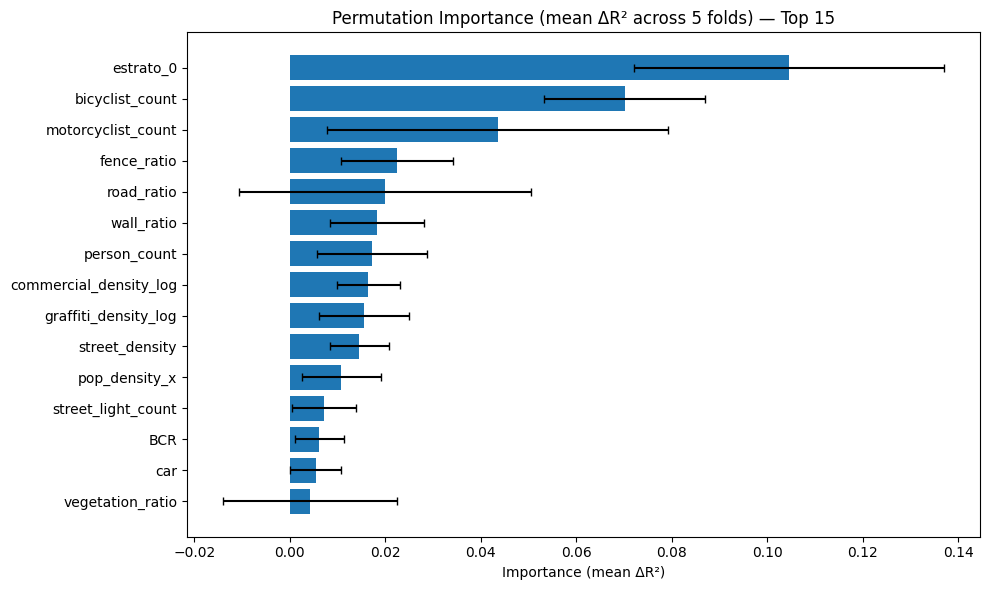

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# ====== K 折交叉验证（默认 5 折，可改 n_splits）======
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_r2, fold_rmse = [], []
pi_all = []   # 收集每折的 permutation importance

for i, (tr_idx, te_idx) in enumerate(kf.split(X), start=1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    rf_params = {
      "n_estimators": 500,     # 森林里树的数量
      "max_depth": 6,          # 限制最大深度
      "min_samples_split": 5,  # 节点至少要 5 个样本才继续分裂
      "min_samples_leaf": 3,   # 叶子节点至少包含 3 个样本
      "max_features": "sqrt",  # 每次分裂时随机选择 sqrt(n_features) 个特征
      "n_jobs": -1,
      "random_state": 42
    }

    rf_params_cv = rf_params.copy()
    rf_params_cv["oob_score"] = False   # 在 CV 中禁用 OOB

    rf_cv = RandomForestRegressor(**rf_params_cv)

    rf_cv.fit(X_tr, y_tr)

    y_hat = rf_cv.predict(X_te)
    r2_cv = r2_score(y_te, y_hat)
    rmse_cv = np.sqrt(mean_squared_error(y_te, y_hat))


    fold_r2.append(r2_cv)
    fold_rmse.append(rmse_cv)

    # 在“验证折”上做 PI（和你单次切分保持一致口径）
    perm_cv = permutation_importance(
        rf_cv, X_te, y_te, n_repeats=20, random_state=42, scoring="r2"
    )
    pi_all.append(pd.DataFrame({
        "feature": X.columns,
        f"imp_fold{i}": perm_cv.importances_mean
    }))

    print(f"Fold {i}: R²={r2_cv:.4f}, RMSE={rmse_cv:.4f}")

# —— 折均值指标 ——
print("\n=== K 折交叉验证汇总 ===")
print(f"平均 R²:   {np.mean(fold_r2):.4f}  ± {np.std(fold_r2):.4f}")
print(f"平均 RMSE: {np.mean(fold_rmse):.4f}  ± {np.std(fold_rmse):.4f}")
print(f"每折 R²:   {np.round(fold_r2, 4)}")
print(f"每折 RMSE: {np.round(fold_rmse, 4)}")

# —— 折均值的 Permutation Importance ——
pi_df_cv = pi_all[0]
for d in pi_all[1:]:
    pi_df_cv = pi_df_cv.merge(d, on="feature", how="inner")

pi_df_cv["imp_mean"] = pi_df_cv.filter(like="imp_fold").mean(axis=1)
pi_df_cv["imp_std"]  = pi_df_cv.filter(like="imp_fold").std(axis=1)
pi_df_cv = pi_df_cv.sort_values("imp_mean", ascending=False).reset_index(drop=True)

print("\n可能妨碍 R² 的特征（折均值 PI<0）：")
bad = pi_df_cv[pi_df_cv["imp_mean"] < 0]
print(bad[["feature","imp_mean","imp_std"]].to_string(index=False) if not bad.empty else "无")

# —— 画折均值 PI ——
topk = min(15, len(pi_df_cv))
plt.figure(figsize=(10,6))
plt.barh(pi_df_cv["feature"].head(topk)[::-1], pi_df_cv["imp_mean"].head(topk)[::-1],
         xerr=pi_df_cv["imp_std"].head(topk)[::-1], capsize=3)
plt.title("Permutation Importance (mean ΔR² across 5 folds) — Top 15")
plt.xlabel("Importance (mean ΔR²)")
plt.tight_layout()
plt.show()


Fold 1: R²=0.4845, RMSE=0.8648
Fold 2: R²=0.5666, RMSE=0.8408
Fold 3: R²=0.4869, RMSE=1.0220
Fold 4: R²=0.1733, RMSE=0.7695
Fold 5: R²=0.4505, RMSE=1.0064

=== 5 折交叉验证汇总 ===
平均 R²:   0.4324 ± 0.1350
平均 RMSE: 0.9007 ± 0.0979


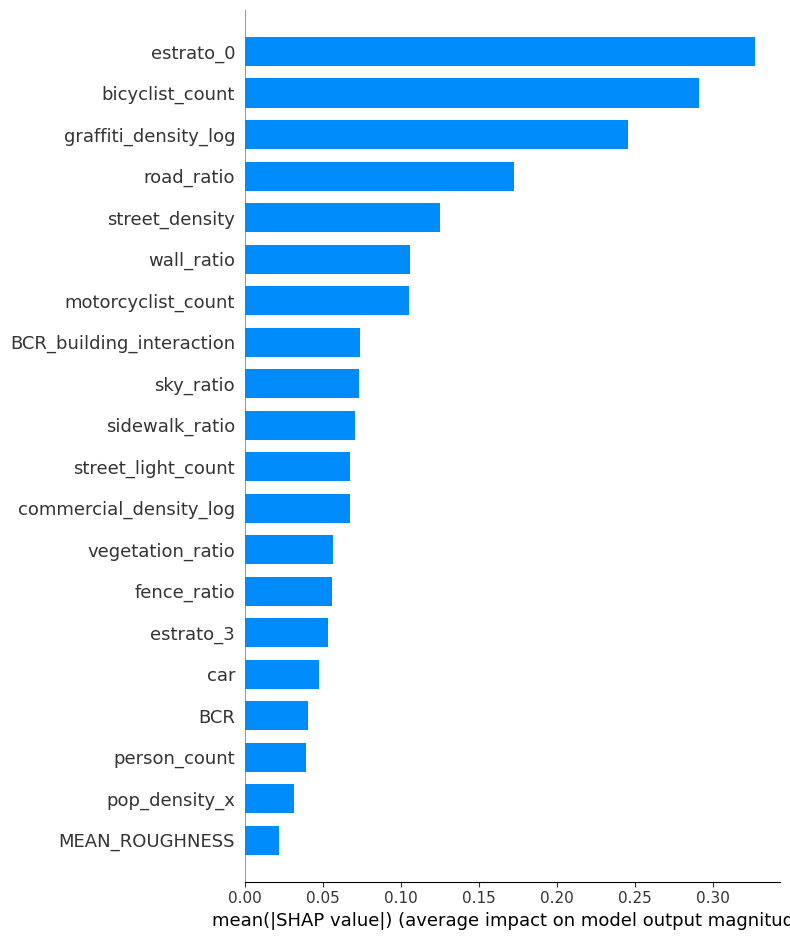

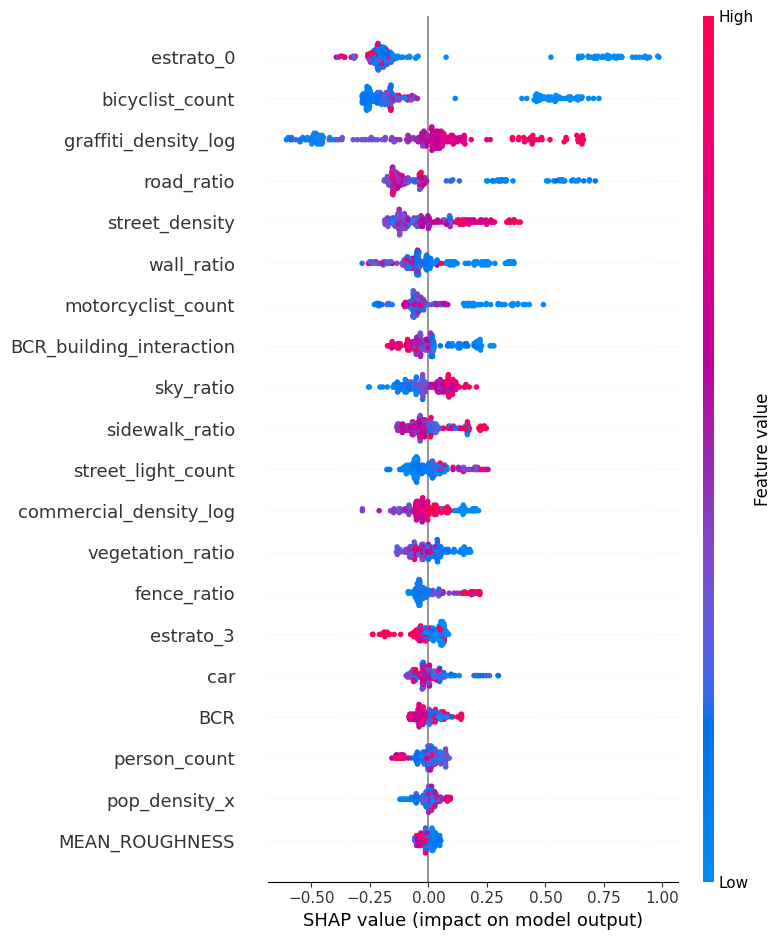

In [24]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# =============== 数据 ===============
X = df[features].copy()
y = df[target].copy()

# =============== XGBoost 参数 ===============
xgb_params = dict(
    learning_rate=0.05,
    max_depth=2,
    n_estimators=500,
    min_child_weight=20,
    gamma=1.35,
    colsample_bytree=0.95,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)

# =============== 五折交叉验证 ===============
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_r2, fold_rmse = [], []
all_shap_values = []
all_expected_value = []
X_all_test = []

for i, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    print(f"Fold {i}: R²={r2:.4f}, RMSE={rmse:.4f}")

    # ========== SHAP ==========
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    all_shap_values.append(shap_values)
    all_expected_value.append(explainer.expected_value)
    X_all_test.append(X_test)

# =============== 汇总结果 ===============
print("\n=== 5 折交叉验证汇总 ===")
print(f"平均 R²:   {np.mean(fold_r2):.4f} ± {np.std(fold_r2):.4f}")
print(f"平均 RMSE: {np.mean(fold_rmse):.4f} ± {np.std(fold_rmse):.4f}")

# =============== SHAP 可视化 ===============
# 合并所有 test 的 SHAP 值
X_all_test = pd.concat(X_all_test, axis=0)
all_shap_values = np.vstack(all_shap_values)

# 总结图（global importance）
shap.summary_plot(all_shap_values, X_all_test, plot_type="bar")

# 点图（显示特征对预测方向/大小的影响）
shap.summary_plot(all_shap_values, X_all_test)


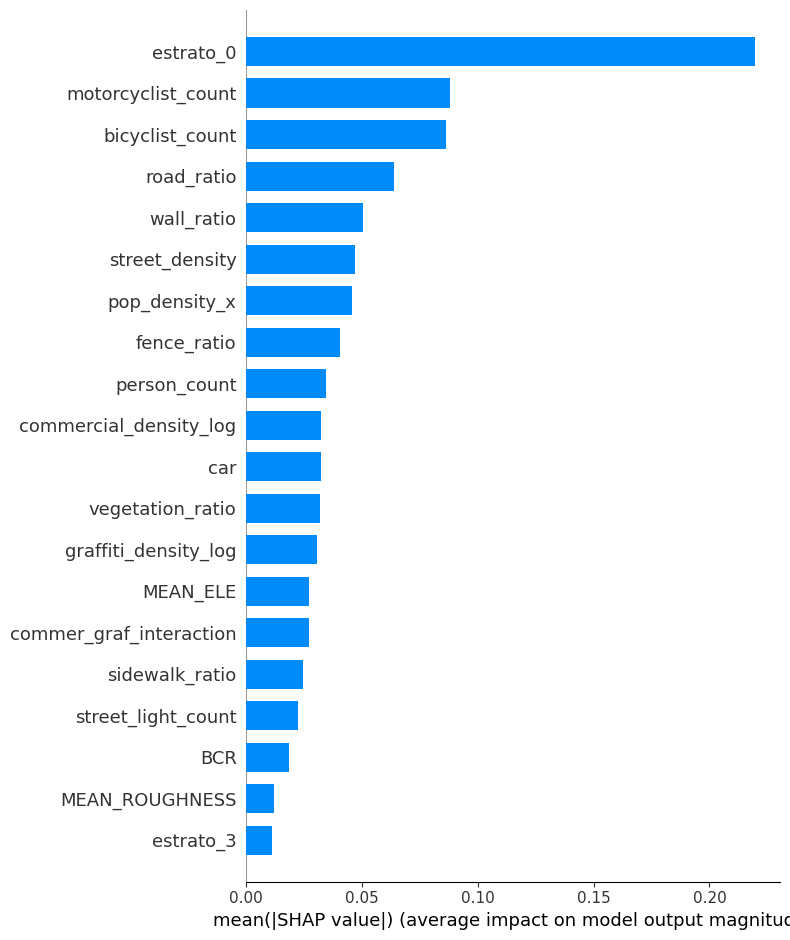

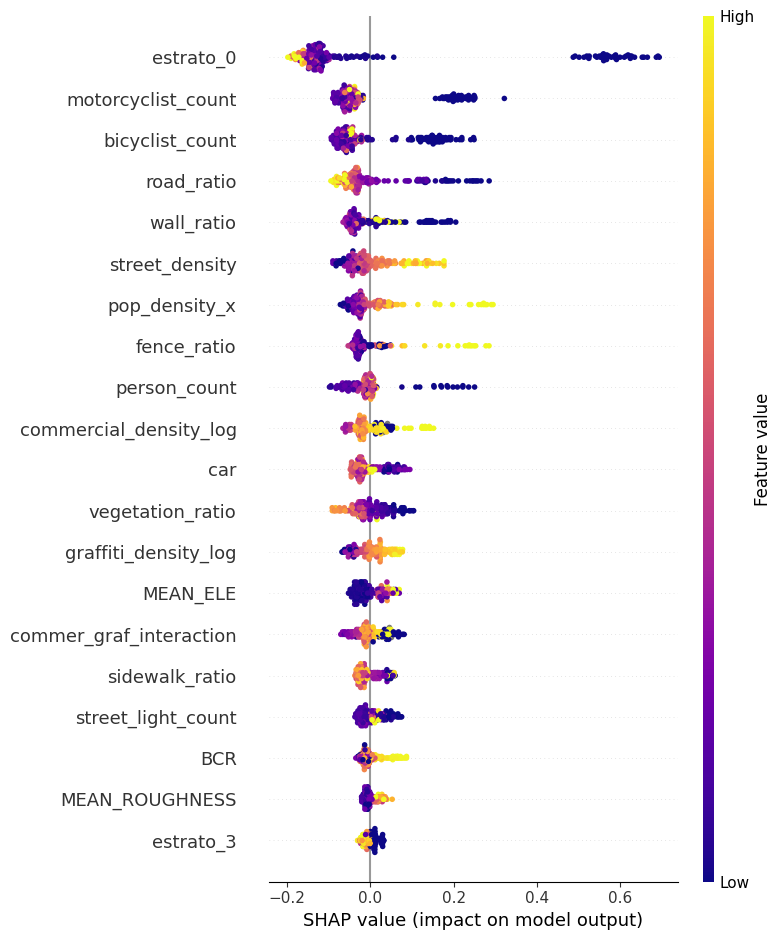

In [ ]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# 1) bar 图 —— 看变量整体重要性（绝对值）
shap.summary_plot(shap_values, X, plot_type="bar")

# 2) 散点图 —— 看变量正负方向 + 数值大小
shap.summary_plot(
    shap_values, X,
    plot_type="dot",
    cmap="plasma"   # 蓝-紫-黄渐变
)



In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

def compute_vif(df, features, add_const=True):
    """
    df: DataFrame
    features: 参与计算的自变量列名（数值型）
    add_const: 是否加入常数项
    """
    X = df[features].select_dtypes(include=[np.number]).copy()
    if add_const:
        X = sm.add_constant(X, has_constant='add')
    vif_list = []
    cols = X.columns
    for i in range(len(cols)):
        vif = variance_inflation_factor(X.values, i)
        vif_list.append((cols[i], vif))
    vif_df = pd.DataFrame(vif_list, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)
    # 常数项通常 VIF 很大，可忽略
    return vif_df

# 用你当前脚本里的 X / features：
vif_df = compute_vif(df_input, features=[
    'commercial_density_log', "vegetation_ratio","street_density", 'sidewalk_ratio', "graffiti_wall_interaction", 'sky_ratio', 'street_light_count', 'estrato_0', 'estrato_1', 'estrato_2', 'estrato_4',
       'estrato_5', 'building_ratio', "graffiti_density_log"  # 有哪个就写哪个
])
print(vif_df)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde  # 若没装 scipy，可把 kde=False

# 让 SVG 里的文字可编辑（不是曲线）
plt.rcParams['svg.fonttype'] = 'none'

def plot_dist_counts(df, col, bins=50, trim=(0.0, 1.0), kde=True, svg_path=None):
    """
    df: DataFrame
    col: 列名，如 'commercial_density'
    bins: 直方图分箱数
    trim: 分位数截断区间，如 (0.05, 0.95) 只看中间 5%~95%
    kde: 是否叠加 KDE（会按分箱宽度缩放到“频次”尺度）
    svg_path: 若给路径则保存为 SVG
    """
    s = df[col].dropna().astype(float)

    # 分位数截断（可选）
    if trim is not None and (trim[0] > 0 or trim[1] < 1):
        lo, hi = s.quantile([trim[0], trim[1]])
        s = s[(s >= lo) & (s <= hi)]

    fig, ax = plt.subplots(figsize=(8, 5))

    # 直方图：density=False → 纵轴就是“频次”
    counts, bin_edges, _ = ax.hist(
        s, bins=bins, density=False, edgecolor='black', alpha=0.7
    )

    ax.set_title(
        f"Distribution of {col}" if trim==(0.0,1.0)
        else f"Distribution of {col} ({int(trim[0]*100)}%-{int(trim[1]*100)}% truncated)"
    )
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")  # 频次

    # KDE 叠加：把密度换算到“频次”刻度（样本量 × 分箱宽度）
    if kde and len(s) > 1:
        try:
            kde_fn = gaussian_kde(s)
            x = np.linspace(s.min(), s.max(), 512)
            bin_width = (bin_edges[1] - bin_edges[0])
            y = kde_fn(x) * len(s) * bin_width
            ax.plot(x, y, linewidth=2, label="KDE (scaled to counts)")
            ax.legend()
        except Exception as e:
            print("KDE 绘制失败（可能未安装 scipy），已仅绘制直方图。", e)

    plt.tight_layout()

    if svg_path:
        fig.savefig(svg_path, format='svg', bbox_inches='tight')
        print(f"SVG 已保存：{svg_path}")

    return fig, ax


"objectid","cod_loc","shape_area","shape_len","codigo_upz","area_m2","population_x","pop_density_x","estrato_0","estrato_1",
"estrato_2","estrato_3","estrato_4","estrato_5","estrato_6","street_total_length","street_len_CL","street_ratio_CL","street_len_KR","street_ratio_KR",
"street_len_None","street_ratio_None","street_len_AK","street_ratio_AK","street_len_TV","street_ratio_TV","street_len_DG","street_ratio_DG","street_len_AC","street_ratio_AC",
"longitude","latitude","fence_ratio","wall_ratio","road_ratio","sidewalk_ratio","building_ratio","sky_ratio","vegetation_ratio","person_count",
"bicyclist_count","motorcyclist_count","other_rider_count","street_light_count","population_y","pop_density_y","murder_rate","Cantidad","graffiti_count","garbage_count",
"file_count","garbage_exist_percentage","graffiti_exist_percentage","file_count_GG","fid","lower_barrio","objectid_2","cod_loc_2","shape_area_2","shape_len_2",
"upz_CAR","graffiti_count_CAR","garbage_count_CAR","file_count_GG_CAR","garbage_exist_percentage_CAR","graffiti_exist_percentage_CAR","file_count_CAR","area_km2","murder_density","count_objects_sum",
"graffiti_density","sample_count","download_count","correction_factor","download_rate","car","count_objects_sum_COM","correction_factor_sampling","commercial_density_log","graffiti_density_log",
"murder_density_log","street_density","graffiti_building_interaction","commer_graf_interaction"


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Distribution of road_ratio (1%-99% truncated)'}, xlabel='road_ratio', ylabel='Frequency'>)

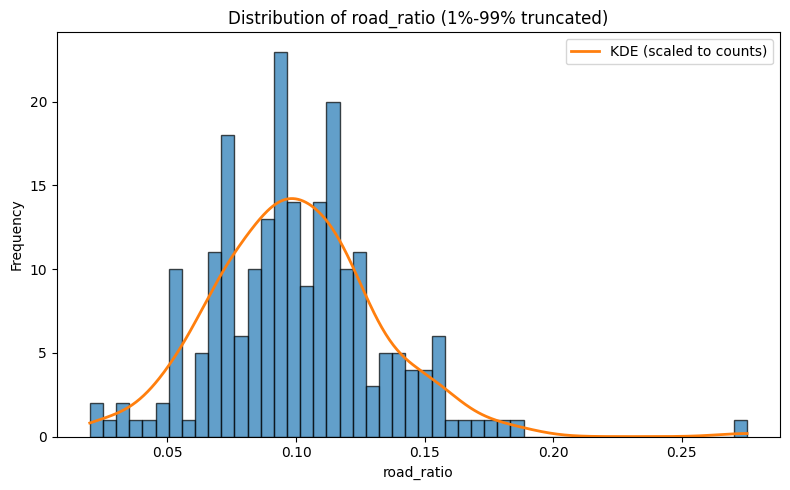

In [ ]:
plot_dist_counts(df_input, 'road_ratio', bins=50, trim=(0.01, 0.99), kde=True, svg_path=None)